# load Data & library

In [4]:
import random
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings(action='ignore') 

In [5]:
PATH = "/Users/jahyeon_gu/Downloads/sentence"

train = pd.read_csv(f"{PATH}/train.csv")
test = pd.read_csv(f"{PATH}/test.csv")

train.shape, test.shape

((16541, 7), (7090, 2))

In [6]:
train.head()

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실


In [7]:
# 중복 데이터 존재, label이 같으면 놔둬도 괜찮지 않을까 싶었지만 레이블이 다른 것도 있어 그냥 모두 제거
train[train["문장"].duplicated()]["문장"].shape

(35,)

In [42]:
temp_df = pd.DataFrame(train[train["문장"].duplicated()]["문장"]).reset_index()
temp_df

,index,문장


In [43]:
for i in train[train["문장"].duplicated()]["문장"].tolist():
    print(train[train["문장"] == i]["label"].unique())

In [44]:
train = train.drop_duplicates("문장")
train.shape

(16506, 7)

# X, y

In [47]:
feature = "문장"
label = ["유형", "극성", "시제", "확실성"]

In [48]:
x = train[feature]
y = train[label[2]]

x.shape, y.shape

((16506,), (16506,))

# Preprocessing x & y

In [49]:
x

0                    0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.
1        이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...
2        정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...
3        서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...
4                 익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.
                               ...                        
16535    이에 따라 대형 콘서트부터 야외 페스티벌, 실내 공연 등 연이어 오픈 소식이 들려오...
16536    ＇신동덤＇은 ＇신비한 동물사전＇과 ＇해리 포터＇ 시리즈를 잇는 마법 어드벤처물로, ...
16537    수족냉증은 어릴 때부터 심했으며 관절은 어디 한 곳이 아니고 목, 어깨, 팔꿈치, ...
16538    김금희 소설가는 ＂계약서 조정이 그리 어려운가 작가를 격려한다면서 그런 문구 하나 ...
16539    1만명이 넘는 방문자수를 기록한 이번 전시회는 총 77개 작품을 넥슨 사옥을 그대로...
Name: 문장, Length: 16506, dtype: object

In [50]:
y

0        현재
1        과거
2        미래
3        과거
4        현재
         ..
16535    현재
16536    과거
16537    과거
16538    과거
16539    과거
Name: 시제, Length: 16506, dtype: object

In [51]:
y_ohe = pd.get_dummies(y)
y_ohe

,과거,미래,현재
0,0,0,1
1,1,0,0
2,0,1,0
3,1,0,0
4,0,0,1
...,...,...,...
16535,0,0,1
16536,1,0,0
16537,1,0,0
16538,1,0,0


In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 500
tokenizer = Tokenizer(num_words=vocab_size, oov_token="[UNK]")
tokenizer

In [53]:
tokenizer.fit_on_texts(x)

In [54]:
x_sequence = tokenizer.texts_to_sequences(x)
x_sequence

[[51, 409, 207, 267, 1, 1, 27, 1, 114, 1],
 [82, 1, 1, 26, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 104, 234],
 [242, 1, 1, 10, 1, 1, 1, 1, 1, 323, 208, 1, 472, 1],
 [1, 52, 136, 1, 1, 1, 1, 1, 1, 410, 114, 1, 1, 1, 1, 1, 1, 13],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 498, 52, 1, 1, 1, 1, 1, 1, 1, 72, 190, 1],
 [1, 1, 364, 147, 1, 1, 1, 1, 1, 1, 2],
 [30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1],
 [59, 1, 1, 1, 1, 1, 499, 1, 1, 1],
 [6, 19, 1, 1, 1, 1, 159, 1, 141, 1, 1, 1, 35, 1],
 [1, 1, 41, 1, 1, 1, 27, 1, 1, 134, 1, 1, 1, 1, 1, 1],
 [1, 1, 10, 1, 415, 1, 1, 224, 115],
 [1, 1, 1, 1, 26, 1, 1, 176, 1, 1, 1, 1, 172, 108],
 [36,
  1,
  324,
  77,
  1,
  1,
  309,
  1,
  5,
  1,
  1,
  1,
  1,
  347,
  1,
  1,
  1,
  122,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [82, 1, 1, 397, 1, 49, 1, 1, 1, 1, 19, 1, 1, 1, 1, 21],
 [1, 1, 1, 1, 24, 1, 1, 1, 34, 8, 1, 1, 13],
 [1, 1, 178, 1, 1, 1, 14, 87, 1, 1, 3, 2],
 [77, 268, 1, 398, 1, 1, 399, 96],
 [1, 30, 1,

In [55]:
test_sequence = tokenizer.texts_to_sequences(test)

In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 150
x_pad = pad_sequences(x_sequence, maxlen=maxlen)
x_pad.shape

(16506, 150)

In [57]:
x_test = pad_sequences(test_sequence, maxlen=maxlen)

# train_test_split

In [58]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_pad, y_ohe, test_size=0.2, stratify=y)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((13204, 150), (3302, 150), (13204, 3), (3302, 3))

In [59]:
type(x_train)

numpy.ndarray

# model

In [60]:
embedding_dim = 8

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, LSTM, Bidirectional

model = Sequential()

model.add(Embedding(vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(LSTM(units=64))
model.add(Dense(64, activation="selu"))
model.add(Dense(y_train.shape[1], activation="softmax"))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"]
)

2022-12-17 19:05:11.294108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-17 19:05:11.294663: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 8)            4000      
                                                                 
 bidirectional (Bidirectiona  (None, 150, 128)         37376     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 128)         98816     
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 3)                 1

In [63]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [66]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, callbacks=[early_stop])

Epoch 1/10
413/413 [==============================] - ETA: 0s - loss: 0.6966 - acc: 0.6746

2022-12-17 19:13:21.720753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-17 19:13:21.955451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-17 19:13:21.964880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-17 19:13:22.331413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-17 19:13:22.340850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-17 19:13:22.710769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


413/413 [==============================] - 96s 232ms/step - loss: 0.6966 - acc: 0.6746 - val_loss: 0.6771 - val_acc: 0.6878
Epoch 2/10
413/413 [==============================] - 91s 221ms/step - loss: 0.6590 - acc: 0.6840 - val_loss: 0.6756 - val_acc: 0.6711
Epoch 3/10
413/413 [==============================] - 93s 225ms/step - loss: 0.6432 - acc: 0.6941 - val_loss: 0.6745 - val_acc: 0.6757
Epoch 4/10
413/413 [==============================] - 93s 224ms/step - loss: 0.6324 - acc: 0.7010 - val_loss: 0.6737 - val_acc: 0.6590
Epoch 5/10
413/413 [==============================] - 90s 218ms/step - loss: 0.6247 - acc: 0.7024 - val_loss: 0.6826 - val_acc: 0.6866
Epoch 6/10
413/413 [==============================] - 91s 219ms/step - loss: 0.6202 - acc: 0.7065 - val_loss: 0.6761 - val_acc: 0.6856
Epoch 7/10
413/413 [==============================] - 90s 219ms/step - loss: 0.6144 - acc: 0.7103 - val_loss: 0.6656 - val_acc: 0.6814
Epoch 8/10
413/413 [==============================] - 91s 220ms/st

In [102]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,acc,val_loss,val_acc
5,0.459807,0.837893,0.480001,0.827440
6,0.451436,0.839178,0.480867,0.834391
7,0.444066,0.841521,0.495749,0.831067
8,0.437611,0.842730,0.490268,0.833787
9,0.429118,0.844544,0.488657,0.830462


<AxesSubplot: >

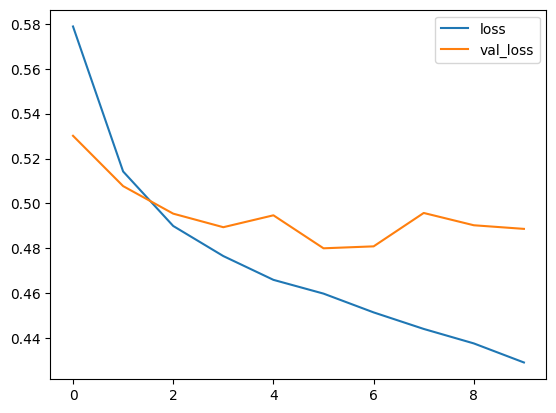

In [103]:
df_hist[["loss", "val_loss"]].plot()

<AxesSubplot: >

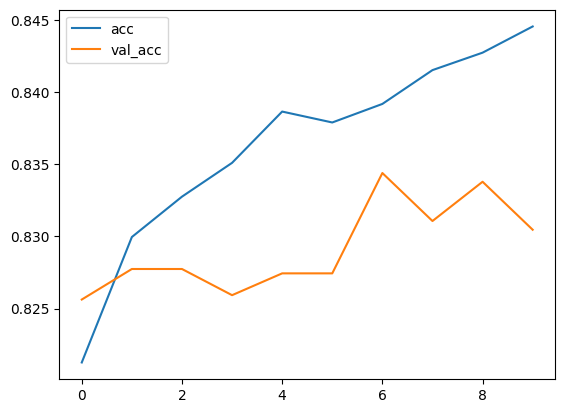

In [104]:
df_hist[["acc", "val_acc"]].plot()

In [111]:
y_pred = model.predict(x_test)
y_pred[:5]

2022-12-15 22:44:36.349681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-15 22:44:36.600985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-15 22:44:36.616140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-15 22:44:37.075064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-15 22:44:37.085036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-15 22:44:37.495326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 25s 103ms/step


array([[1.7756334e-02, 8.6487842e-01, 5.0219130e-03, 1.1234341e-01],
       [1.1421599e-02, 8.0231881e-01, 2.8351706e-03, 1.8342440e-01],
       [2.1665009e-02, 8.0012685e-01, 1.8647040e-03, 1.7634344e-01],
       [1.2211975e-02, 9.5323271e-01, 4.0036715e-03, 3.0551679e-02],
       [1.5692390e-04, 9.9729437e-01, 1.4596625e-04, 2.4027142e-03]],
      dtype=float32)

In [113]:
np.argmax(y_pred, axis=1)

array([1, 1, 1, ..., 1, 1, 1])

In [115]:
y_ohe.columns

Index(['대화형', '사실형', '예측형', '추론형'], dtype='object')

In [117]:
y_ohe.columns[np.argmax(y_pred, axis=1)].value_counts()

사실형    6344
추론형     577
대화형     104
예측형      65
dtype: int64

# 함수

In [160]:
label = ["유형", "극성", "시제", "확실성"]
train[label[3]]


0         확실
1         확실
2         확실
3         확실
4         확실
        ... 
16536     확실
16537     확실
16538     확실
16539    불확실
16540     확실
Name: 확실성, Length: 16541, dtype: object

In [29]:
def sentense(train, test, idx):
    maxlen = 150
    embedding_dim = 8
    vocab_size = 500
    
    feature = "문장"
    label = ["유형", "극성", "시제", "확실성"]
    
    x = train[feature]
    y = train[label[idx]]
    t = test[feature]

    y_train = pd.get_dummies(y)

    vocab_size = 500
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="[UNK]")
    tokenizer.fit_on_texts(x)
    x_sequence = tokenizer.texts_to_sequences(x)
    t_sequence = tokenizer.texts_to_sequences(t)

    maxlen = 150
    x_train = pad_sequences(x_sequence, maxlen=maxlen)
    x_test = pad_sequences(t_sequence, maxlen=maxlen)

    if idx != 3:
        model = Sequential()
        model.add(Embedding(vocab_size, output_dim=embedding_dim, input_length=maxlen))
        model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
        model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
        model.add(LSTM(units=32))
        model.add(Dense(16, activation="selu"))
        model.add(Dense(y_train.shape[1], activation="softmax"))

        model.compile(
            optimizer="adam",
            loss="categorical_crossentropy",
            metrics=["acc"]
        )
    else:
        model = Sequential()
        model.add(Embedding(vocab_size, output_dim=embedding_dim, input_length=maxlen))
        model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
        model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
        model.add(LSTM(units=32))
        model.add(Dense(616, activation="selu"))
        model.add(Dense(y_train.shape[1], activation="sigmoid"))
        
        model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["acc"]
        )
    
    early_stop = EarlyStopping(monitor='loss', patience=3)
    history = model.fit(x_train, y_train, epochs=10, callbacks=[early_stop])
    
    y_pred = model.predict(x_test)
    y_predict = y_train.columns[np.argmax(y_pred, axis=1)]
    
    return y_predict

In [30]:
a = sentense(train, test, 0)

Epoch 1/10


2022-12-16 08:53:43.234054: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-16 08:53:46.064027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 08:53:46.681691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 08:53:46.695851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 08:53:47.097879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 08:53:47.111396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 08:53:47.467874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

517/517 [==============================] - 104s 190ms/step - loss: 0.6059 - acc: 0.8186
Epoch 2/10
517/517 [==============================] - 95s 184ms/step - loss: 0.5366 - acc: 0.8287
Epoch 3/10
517/517 [==============================] - 98s 189ms/step - loss: 0.5119 - acc: 0.8321
Epoch 4/10
517/517 [==============================] - 100s 194ms/step - loss: 0.5001 - acc: 0.8346
Epoch 5/10
517/517 [==============================] - 100s 194ms/step - loss: 0.4910 - acc: 0.8351
Epoch 6/10
517/517 [==============================] - 98s 190ms/step - loss: 0.4818 - acc: 0.8371
Epoch 7/10
517/517 [==============================] - 98s 189ms/step - loss: 0.4762 - acc: 0.8380
Epoch 8/10
517/517 [==============================] - 100s 194ms/step - loss: 0.4714 - acc: 0.8385
Epoch 9/10
517/517 [==============================] - 99s 192ms/step - loss: 0.4638 - acc: 0.8371
Epoch 10/10
517/517 [==============================] - 100s 193ms/step - loss: 0.4598 - acc: 0.8382


2022-12-16 09:10:16.963157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:10:17.191921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:10:17.201504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:10:17.590034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:10:17.599299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:10:17.976432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 26s 108ms/step


In [31]:
b = sentense(train, test, 1)

Epoch 1/10


2022-12-16 09:10:46.607581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:10:47.249345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:10:47.263222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:10:47.651057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:10:47.665525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:10:48.036535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:10:48.307794: I tensorflow/core/grappler/optimizers/cust

517/517 [==============================] - 112s 203ms/step - loss: 0.2152 - acc: 0.9550
Epoch 2/10
517/517 [==============================] - 100s 194ms/step - loss: 0.1497 - acc: 0.9671
Epoch 3/10
517/517 [==============================] - 101s 195ms/step - loss: 0.1420 - acc: 0.9675
Epoch 4/10
517/517 [==============================] - 101s 196ms/step - loss: 0.1388 - acc: 0.9687
Epoch 5/10
517/517 [==============================] - 101s 195ms/step - loss: 0.1340 - acc: 0.9694
Epoch 6/10
517/517 [==============================] - 101s 196ms/step - loss: 0.1317 - acc: 0.9695
Epoch 7/10
517/517 [==============================] - 101s 196ms/step - loss: 0.1300 - acc: 0.9699
Epoch 8/10
517/517 [==============================] - 100s 193ms/step - loss: 0.1289 - acc: 0.9696
Epoch 9/10
517/517 [==============================] - 100s 194ms/step - loss: 0.1260 - acc: 0.9697
Epoch 10/10
517/517 [==============================] - 100s 193ms/step - loss: 0.1237 - acc: 0.9702


2022-12-16 09:27:40.832554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:27:41.091036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:27:41.101852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:27:41.521761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:27:41.531199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:27:41.920035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 26s 109ms/step


In [32]:
c = sentense(train, test, 2)

Epoch 1/10


2022-12-16 09:28:10.845533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:28:11.476771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:28:11.491232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:28:11.899292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:28:11.915248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:28:12.307631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:28:12.604637: I tensorflow/core/grappler/optimizers/cust

517/517 [==============================] - 111s 202ms/step - loss: 0.7714 - acc: 0.6216
Epoch 2/10
517/517 [==============================] - 101s 196ms/step - loss: 0.6824 - acc: 0.6815
Epoch 3/10
517/517 [==============================] - 98s 189ms/step - loss: 0.6540 - acc: 0.6907
Epoch 4/10
517/517 [==============================] - 101s 195ms/step - loss: 0.6392 - acc: 0.6962
Epoch 5/10
517/517 [==============================] - 98s 189ms/step - loss: 0.6303 - acc: 0.7004
Epoch 6/10
517/517 [==============================] - 99s 192ms/step - loss: 0.6244 - acc: 0.7026
Epoch 7/10
517/517 [==============================] - 99s 192ms/step - loss: 0.6191 - acc: 0.7059
Epoch 8/10
517/517 [==============================] - 100s 194ms/step - loss: 0.6143 - acc: 0.7114
Epoch 9/10
517/517 [==============================] - 101s 195ms/step - loss: 0.6101 - acc: 0.7156
Epoch 10/10
517/517 [==============================] - 101s 196ms/step - loss: 0.6061 - acc: 0.7192


2022-12-16 09:44:58.500346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:44:58.743759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:44:58.754498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:44:59.199560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:44:59.209405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:44:59.638435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 26s 110ms/step


In [33]:
d = sentense(train, test, 3)

Epoch 1/10


2022-12-16 09:45:29.392839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:45:30.405845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:45:30.423421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:45:30.920005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:45:30.935710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:45:31.427878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 09:45:31.905312: I tensorflow/core/grappler/optimizers/cust

517/517 [==============================] - 111s 199ms/step - loss: 0.2603 - acc: 0.9192
Epoch 2/10
517/517 [==============================] - 102s 197ms/step - loss: 0.2301 - acc: 0.9229
Epoch 3/10
517/517 [==============================] - 101s 195ms/step - loss: 0.2237 - acc: 0.9241
Epoch 4/10
517/517 [==============================] - 95s 184ms/step - loss: 0.2215 - acc: 0.9263
Epoch 5/10
517/517 [==============================] - 93s 180ms/step - loss: 0.2183 - acc: 0.9262
Epoch 6/10
517/517 [==============================] - 93s 180ms/step - loss: 0.2174 - acc: 0.9261
Epoch 7/10
517/517 [==============================] - 96s 187ms/step - loss: 0.2140 - acc: 0.9261
Epoch 8/10
517/517 [==============================] - 97s 187ms/step - loss: 0.2108 - acc: 0.9275
Epoch 9/10
517/517 [==============================] - 98s 190ms/step - loss: 0.2080 - acc: 0.9287
Epoch 10/10
517/517 [==============================] - 102s 198ms/step - loss: 0.2060 - acc: 0.9294


2022-12-16 10:01:55.406108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 10:01:55.667590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 10:01:55.683528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 10:01:56.154601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 10:01:56.164623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-16 10:01:56.640662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 27s 111ms/step


# submit

In [36]:
submit = pd.read_csv(f"{PATH}/sample_submission.csv")
submit.tail()

,ID,label
7085,TEST_7085,추론형-긍정-현재-확실
7086,TEST_7086,추론형-긍정-현재-확실
7087,TEST_7087,추론형-긍정-현재-확실
7088,TEST_7088,추론형-긍정-현재-확실
7089,TEST_7089,추론형-긍정-현재-확실


In [38]:
# 0.830462
score = df_hist.iloc[-1, -1].round(5)
score

NameError: name 'df_hist' is not defined

In [134]:
file_name = f"/Users/jahyeon_gu/Downloads/sentence/submit{score}.csv"
file_name

'submit0.83046.csv'

In [35]:
submit_content = a + "-" + b + "-" + c + "-" + d
submit_content

Index(['사실형-긍정-과거-확실', '사실형-긍정-과거-확실', '사실형-긍정-과거-확실', '사실형-긍정-과거-확실',
       '사실형-긍정-과거-확실', '사실형-긍정-미래-확실', '사실형-긍정-미래-확실', '사실형-긍정-현재-확실',
       '사실형-긍정-현재-확실', '사실형-긍정-과거-확실',
       ...
       '사실형-긍정-과거-확실', '사실형-긍정-과거-확실', '사실형-긍정-과거-확실', '사실형-긍정-현재-확실',
       '사실형-긍정-현재-확실', '사실형-긍정-현재-확실', '사실형-긍정-현재-확실', '사실형-긍정-현재-확실',
       '추론형-긍정-미래-확실', '사실형-긍정-현재-확실'],
      dtype='object', length=7090)

In [37]:
submit['label'] = submit_content
submit.tail()

,ID,label
7085,TEST_7085,사실형-긍정-현재-확실
7086,TEST_7086,사실형-긍정-현재-확실
7087,TEST_7087,사실형-긍정-현재-확실
7088,TEST_7088,추론형-긍정-미래-확실
7089,TEST_7089,사실형-긍정-현재-확실


In [41]:
submit.to_csv(file_name, index=False)

In [42]:
pd.read_csv(file_name)

,ID,label
0,TEST_0000,사실형-긍정-과거-확실
1,TEST_0001,사실형-긍정-과거-확실
2,TEST_0002,사실형-긍정-과거-확실
3,TEST_0003,사실형-긍정-과거-확실
4,TEST_0004,사실형-긍정-과거-확실
...,...,...
7085,TEST_7085,사실형-긍정-현재-확실
7086,TEST_7086,사실형-긍정-현재-확실
7087,TEST_7087,사실형-긍정-현재-확실
7088,TEST_7088,추론형-긍정-미래-확실
